# Notebook 2: Core Implementation & Module Testing

This notebook tests all modules in `src/` directory to verify functionality before running full experiments.

## Testing Coverage:

1. **PartialCrossEntropyLoss** - handles partial labels with ignore_index=-1
2. **UNet/UNet++** - forward pass and output shapes
3. **Metrics** - IoU and pixel accuracy computation
4. **LandCoverDataset** - data loading with split files
5. **Trainer** - training loop with real data


In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src import (
    set_seed, mask_to_rgb, visualize_sample,
    LandCoverDataset, mask_labels_random,
    get_unet, UNet, UNetPlusPlus,
    PartialCrossEntropyLoss,
    compute_iou, compute_pixel_accuracy, MetricsTracker,
    Trainer
)
from src.dataset import get_train_transform, get_val_transform

set_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

%matplotlib inline

Random seed set to 42
Device: cuda


## 1. Test Partial Cross Entropy Loss


In [2]:
loss_fn = PartialCrossEntropyLoss(ignore_index=-1)

# Test with 5 classes (background, buildings, woodlands, water, roads)
logits = torch.randn(4, 5, 64, 64).to(device)
targets = torch.randint(0, 5, (4, 64, 64)).to(device)

targets[0, :32, :32] = -1

loss = loss_fn(logits, targets)

print(f"✓ Partial CE Loss computed: {loss.item():.4f}")
print(f"✓ Loss requires grad: {loss.requires_grad}")
print(f"✓ Valid pixels: {(targets != -1).sum().item()}/{targets.numel()}")

all_unlabeled = torch.full((4, 64, 64), -1, dtype=torch.long).to(device)
loss_zero = loss_fn(logits, all_unlabeled)
print(f"✓ All unlabeled loss: {loss_zero.item():.4f}")

print("\n✅ PartialCrossEntropyLoss working correctly with 5 classes!")

✓ Partial CE Loss computed: 1.9877
✓ Loss requires grad: False
✓ Valid pixels: 15360/16384
✓ All unlabeled loss: 0.0000

✅ PartialCrossEntropyLoss working correctly with 5 classes!


## 2. Test UNet Model


In [3]:
model = get_unet(model_type='unet', classes=5, in_channels=3).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model parameters: {num_params:,}")

# Test with 512x512 input (actual patch size)
test_input = torch.randn(2, 3, 512, 512).to(device)
test_output = model(test_input)

print(f"✓ Input shape: {test_input.shape}")
print(f"✓ Output shape: {test_output.shape}")
print(f"✓ Expected: (2, 5, 512, 512)")

assert test_output.shape == (2, 5, 512, 512), "Output shape mismatch!"

print("\n✅ UNet model working correctly with 512x512 inputs!")

Created local UNet implementation
✓ Model parameters: 13,391,621
✓ Input shape: torch.Size([2, 3, 512, 512])
✓ Output shape: torch.Size([2, 5, 512, 512])
✓ Expected: (2, 5, 512, 512)

✅ UNet model working correctly with 512x512 inputs!


## 3. Test Metrics


In [4]:
predictions = test_output.argmax(dim=1).cpu()
targets = torch.randint(0, 5, (2, 512, 512))

iou_dict = compute_iou(predictions, targets, num_classes=5, ignore_index=-1)
accuracy = compute_pixel_accuracy(predictions, targets, ignore_index=-1)

print(f"✓ Mean IoU: {iou_dict['mean_iou']:.4f}")
print(f"✓ Pixel Accuracy: {accuracy:.4f}")

class_names = ['background', 'buildings', 'woodlands', 'water', 'roads']
for i in range(5):
    print(f"  {class_names[i]} IoU: {iou_dict[f'class_{i}_iou']:.4f}")

tracker = MetricsTracker(num_classes=5, ignore_index=-1)
tracker.update(predictions, targets)
metrics = tracker.get_metrics()

print(f"\n✓ Tracker mean IoU: {metrics['mean_iou']:.4f}")

print("\n✅ Metrics working correctly with 5 classes!")

✓ Mean IoU: 0.0924
✓ Pixel Accuracy: 0.2005
  background IoU: 0.0442
  buildings IoU: 0.1117
  woodlands IoU: 0.0243
  water IoU: 0.1136
  roads IoU: 0.1681

✓ Tracker mean IoU: 0.0924

✅ Metrics working correctly with 5 classes!


## 5. Test LandCoverDataset with Real Data

Test the dataset loader with the actual downloaded LandCover.ai data using split files.


✓ Loaded 7470 patches from train.txt
✓ Train dataset loaded: 7470 patches
✓ Loaded 1602 patches from val.txt
✓ Val dataset loaded: 1602 patches

✓ Sample image shape: torch.Size([3, 512, 512])
✓ Sample mask shape: torch.Size([512, 512])
✓ Unique mask values: [-1, 0, 2]
✓ Labeled pixels: 30.00% (target: 30%)


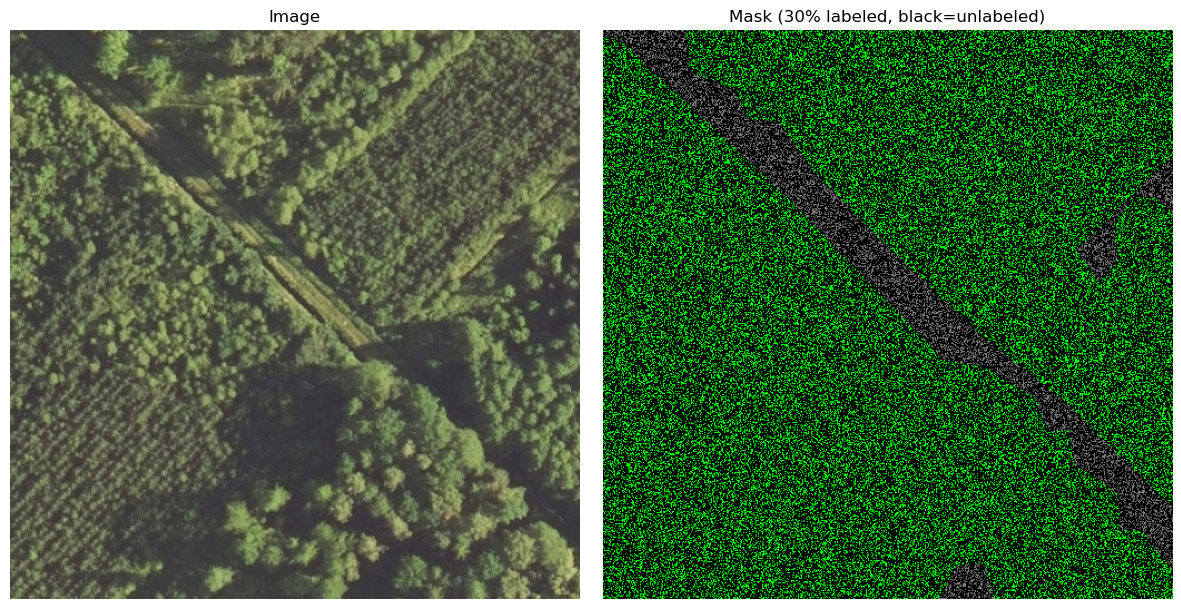


✅ LandCoverDataset working correctly with real data!


In [5]:
# Test dataset with real data and split files
data_dir = Path("../data")

# Test train split
train_dataset = LandCoverDataset(
    data_dir=data_dir,
    split='train',
    transform=get_train_transform(),
    labeled_fraction=0.3,
    seed=42,
    use_split_file=True
)

print(f"✓ Train dataset loaded: {len(train_dataset)} patches")

# Test validation split
val_dataset = LandCoverDataset(
    data_dir=data_dir,
    split='val',
    transform=get_val_transform(),
    labeled_fraction=1.0,  # Full labels for validation
    seed=42,
    use_split_file=True
)

print(f"✓ Val dataset loaded: {len(val_dataset)} patches")

# Get a sample
sample = train_dataset[0]
img, mask = sample
print(f"\n✓ Sample image shape: {img.shape}")
print(f"✓ Sample mask shape: {mask.shape}")
print(f"✓ Unique mask values: {torch.unique(mask).tolist()}")

# Check if partial masking worked
labeled_ratio = (mask != -1).sum() / mask.numel()
print(f"✓ Labeled pixels: {labeled_ratio:.2%} (target: 30%)")

# Visualize a sample
img_np = img.permute(1, 2, 0).numpy()
# Denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_np = std * img_np + mean
img_np = np.clip(img_np, 0, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_np)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(mask_to_rgb(mask.numpy()))
axes[1].set_title('Mask (30% labeled, black=unlabeled)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\n✅ LandCoverDataset working correctly with real data!")

## 6. Test Trainer (Quick Mock Run)


In [6]:
from torch.utils.data import DataLoader, Subset

# Use small subset for quick testing (first 10 samples)
train_subset = Subset(train_dataset, range(min(10, len(train_dataset))))
val_subset = Subset(val_dataset, range(min(10, len(val_dataset))))

train_loader = DataLoader(train_subset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=2, shuffle=False)

# Initialize model for 5 classes
mock_model = get_unet(model_type='unet', classes=5, in_channels=3)
optimizer = torch.optim.Adam(mock_model.parameters(), lr=1e-3)
criterion = PartialCrossEntropyLoss(ignore_index=-1)

# Create trainer
trainer = Trainer(
    model=mock_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    mode='partial_ce',
    num_classes=5,
    ignore_index=-1
)

print("✓ Trainer initialized with 5 classes")

# Run 1 epoch
history = trainer.fit(num_epochs=1, save_best=False)

print(f"\n✓ Completed 1 training epoch")
print(f"  Train loss: {history['train_loss'][0]:.4f}")
print(f"  Val loss: {history['val_loss'][0]:.4f}")
print(f"  Val mIoU: {history['val_miou'][0]:.4f}")
print(f"  Val pixel acc: {history['val_acc'][0]:.4f}")

print("\n✅ Trainer working correctly with real LandCover data!")

Created local UNet implementation
✓ Trainer initialized with 5 classes

Starting training for 1 epochs
Mode: partial_ce
Device: cuda
Train batches: 5
Val batches: 5
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.75it/s, loss=1.5194]


Epoch 1/1
  Train Loss: 1.4790
  Val Loss: 1.5298
  Val mIoU: 0.1442
  Val Acc: 0.4924

Training completed!
Best validation mIoU: 0.0000

✓ Completed 1 training epoch
  Train loss: 1.4790
  Val loss: 1.5298
  Val mIoU: 0.1442
  Val pixel acc: 0.4924

✅ Trainer working correctly with real LandCover data!


---

## ✅ All Core Modules Verified!

All components from `src/` have been successfully tested:

1. **PartialCrossEntropyLoss** - Handles partial labels with `ignore_index=-1`
2. **UNet Model** - Forward pass generates correct output shapes
3. **Metrics** - IoU and pixel accuracy computed correctly
4. **LandCoverDataset** - Loads data with configurable label masking
5. **Trainer** - Training loop works correctly with partial supervision

The implementation is ready for full experiments on the LandCover.ai dataset!
